INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
(50000, 32, 32, 1) (50000, 10) (10000, 32, 32, 1) (10000, 10)


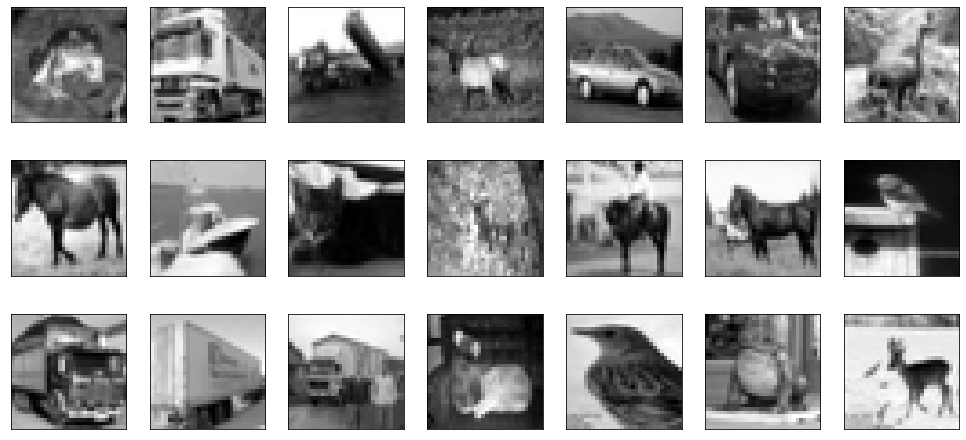

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import cv2

K.set_image_data_format('channels_last')

def load_cifar():
    from tensorflow.keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
    x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return (x_train, y_train), (x_test, y_test)
    
(x_train, y_train), (x_test, y_test) = load_cifar()

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(17, 8))
index = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title('')
        axes[i,j].imshow(x_train[index], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()


In [2]:
from capsnet.capsnet import CapsNet

ROUTINGS = 3
BATCH_SIZE = 100
INPUT_SHAPE = (32, 32, 1)
N_CLASS = 10

model, eval_model, manipulate_model = CapsNet(input_shape=INPUT_SHAPE,
                                              n_class=N_CLASS,
                                              routings=ROUTINGS,
                                              batch_size=BATCH_SIZE)
model.summary()


starting CapsNet (32, 32, 1) 10 3 100
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(100, 32, 32, 1)]   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (100, 24, 24, 256)   20992       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (100, 8, 8, 256)     5308672     conv1[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (100, 2048, 8)       0           conv2d[0][0]                     
________________________________________________________

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    mean = tf.reduce_mean(tf.reduce_sum(L, 1))
    return mean


lr = 0.001
lam_recon = 0.392
# compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                loss=[margin_loss, 'mse'],
                loss_weights=[1., lam_recon],
                metrics={'capsnet': 'accuracy'})
# tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)


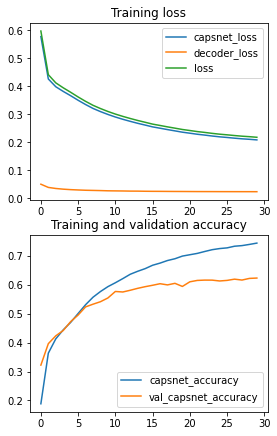

In [4]:
from utils.utils import combine_images, plot_log
from metrics import get_callbacks
run_fit = False
save_dir='./result/capsnet_cifar/capsnet_cifar_mono'
weights = save_dir + '/trained_model.h5'

def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        for next_generated in generator:
            yield (next_generated[0], next_generated[1]), (next_generated[1], next_generated[0])

net_callbacks = get_callbacks(save_dir, lr)
if(run_fit):
    model.fit(train_generator(x_train, y_train, BATCH_SIZE),
                steps_per_epoch=int(y_train.shape[0] / BATCH_SIZE),
                epochs=30,
                validation_data=((x_test, y_test), (y_test, x_test)),
                batch_size=BATCH_SIZE,
                callbacks=[net_callbacks])
    model.save_weights(save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)
else:
    model.load_weights(weights)

plot_log(save_dir + '/log.csv', show=True)

c:\Users\Tautvydas\Documents\magistras\master_capsnet\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0-rc2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


------------------------------Begin: test------------------------------
Reconstructed images are saved to ./result/capsnet_cifar/capsnet_cifar_mono/images_eval.png
------------------------------End: test------------------------------


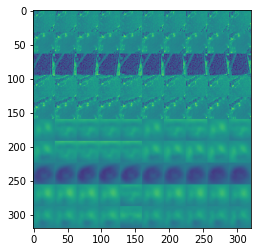

------------------------------Begin: test------------------------------
Reconstructed images are saved to ./result/capsnet_cifar/capsnet_cifar_mono/x_test.png
------------------------------End: test------------------------------


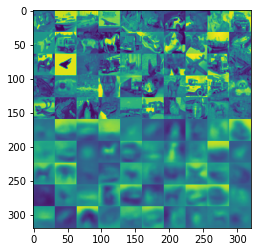

In [5]:
from images import get_images_eval, predict_and_print

images_eval = get_images_eval(1)

predict_and_print(save_dir, eval_model, images_eval, "images_eval")
predict_and_print(save_dir, eval_model, x_test, "x_test")
